# Read raw continuous data from an SDS archive

https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html#module-obspy.clients.filesystem.sds

In [1]:
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')
EVENTS_DIR = Path.cwd().parents[1].joinpath('data','events')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in tools.tree(Path.cwd().joinpath(SDS_DIR)):
    print(line)

# Set start time
stime = obspy.UTCDateTime("2003196T")
print(stime)

# Get a list of NSLCs
#print(sdsclient.get_all_nslc(datetime=stime))

Tree listing of SDS_DIR directory
├── .DS_Store
├── 2009
│   └── AV
│       └── REF
│           └── EHZ.D
│               └── AV.REF..EHZ.D.2009.081
├── ._2009
└── 2003
    ├── .DS_Store
    └── MV
        ├── MBLG
        │   └── SHZ.D
        │       ├── MV.MBLG..SHZ.D.2003.194
        │       ├── MV.MBLG..SHZ.D.2003.193
        │       ├── MV.MBLG..SHZ.D.2003.192
        │       ├── MV.MBLG..SHZ.D.2003.195
        │       ├── MV.MBLG..SHZ.D.2003.197
        │       └── MV.MBLG..SHZ.D.2003.196
        ├── MBRY
        │   └── BHZ.D
        │       ├── MV.MBRY..BHZ.D.2003.195
        │       ├── MV.MBRY..BHZ.D.2003.192
        │       ├── MV.MBRY..BHZ.D.2003.193
        │       ├── MV.MBRY..BHZ.D.2003.194
        │       ├── MV.MBRY..BHZ.D.2003.196
        │       └── MV.MBRY..BHZ.D.2003.197
        ├── .DS_Store
        ├── MBWH
        │   └── SHZ.D
        │       ├── MV.MBWH..SHZ.D.2003.192
        │       ├── MV.MBWH..SHZ.D.2003.195
        │       ├── MV.MBWH..SHZ.D.2003.194
   

In [2]:
# Get and plot data
seconds = 3600
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
#st.plot(equal_scale=False);

# Remove bad waveforms

In [3]:
st.remove(st.select(id='MV.MBLY..BHZ')[0])
st.remove(st.select(id='MV.MBGB..BHZ')[0])
#st.plot(equal_scale=False);

6 Trace(s) in Stream:
MV.MBGH..BHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples
MV.MBLG..SHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples
MV.MBRV..SHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples
MV.MBRY..BHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples
MV.MBSS..SHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples
MV.MBWH..SHZ | 2003-07-15T00:00:00.000000Z - 2003-07-15T01:00:00.000000Z | 75.0 Hz, 270001 samples

# Run STA/LTA Detector on a single channel

In [4]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta, recursive_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

#plot_trigger(st2[tr_index], cft, threshON, threshOFF)

sampling_rate=75


# Run STA/LTA on whole Stream object (network trigger)

In [5]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3
max_secs = 120.0

#staltamethod = "recstalta"
#staltamethod = 'carlstatrig'
staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    #pprint(this_trig)


 Event 0

 Event 1

 Event 2


# Convert triggers to events and store in a (VolcanoSeismic)Catalog object

3 Event(s) in Catalog:
2003-07-15T00:20:33.240000Z | None, None | 2.96 None
2003-07-15T00:33:13.720000Z | None, None | 2.74 None
2003-07-15T00:58:54.880000Z | None, None | 2.89 None
                     magnitude        energy latitude longitude depth  \
datetime                                                                
2003-07-15 00:00:00   2.956567  27217.686964        0         0     0   
2003-07-15 00:30:00   5.632615  34582.543211        0         0     0   

                     durations                        filename  counts  \
datetime                                                                 
2003-07-15 00:00:00  22.240000                 20030715T002033       1   
2003-07-15 00:30:00  36.733333  20030715T00331320030715T005854       2   

                     cumcounts     cumenergy  
datetime                                      
2003-07-15 00:00:00          1  27217.686964  
2003-07-15 00:30:00          3  61800.230175  


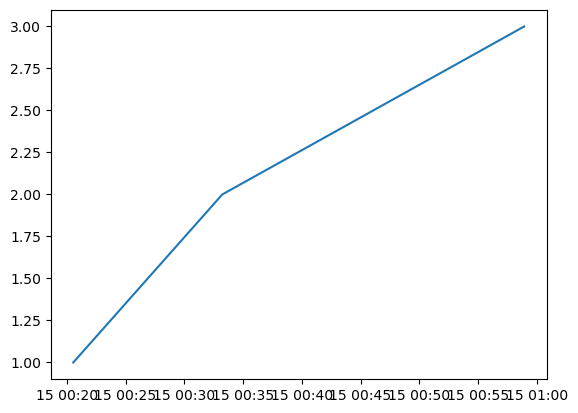

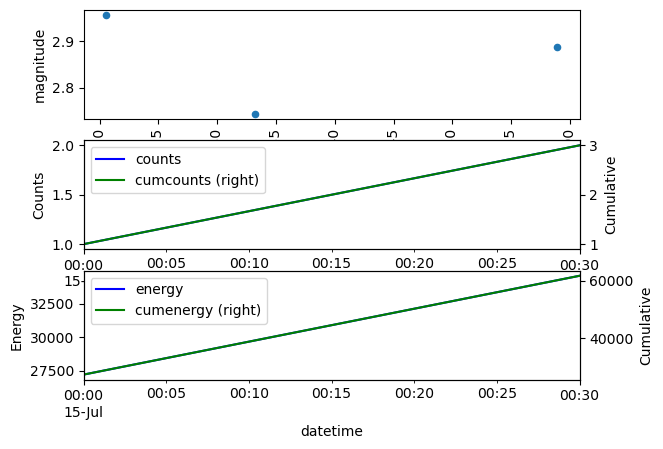

In [6]:
import pandas as pd
pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
catalogObj = tools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                  sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)
dir(catalogObj)
#cat.get_times()
catalogObj.plot_eventrate(binsize=pd.Timedelta(minutes=30), )
#catalogObj.plot_streams()
        

So we have the basic ability to detect events. Probably not very well. But then we could run it on multiple days of data and create a multi-day catalog. Then try running a simple event classifier on it, based on RSAM ratios or spectral metrics or full-blown ML features.

In [7]:
dir(catalogObj)

['__add__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_creation_info',
 '_get_resource_id',
 '_repr_pretty_',
 '_set_creation_info',
 '_set_resource_id',
 'addEvent',
 'append',
 'catalog2dataframe',
 'clear',
 'comments',
 'concat',
 'copy',
 'count',
 'creation_info',
 'description',
 'endtime',
 'events',
 'extend',
 'filter',
 'get_times',
 'miniseedfiles',
 'plot',
 'plot_eventrate',
 'plot_streams',
 'resource_id',
 'save',
 'starttime',
 'streams',
 'triggerParams',
 'triggers',
 'write',
 'write_events']

# Run coincidence trigger on multiple days, and append catalogs

In [8]:
import sys
from pprint import pprint 
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')
EVENTS_DIR = Path.cwd().parents[1].joinpath('data','events')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

from obspy.signal.trigger import coincidence_trigger

# set parameters
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta'
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')

pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   

catalog_all = None

for jday in range(192, 198, 1): # Loop over days in SDS archive

    for hour in range(24):

        # set start time
        stime = obspy.UTCDateTime(f"2003{jday}T") + hour * 3600
        print(stime)
    
        # Get and plot data
        st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+3600)
        if len(st)==0:
            continue
    
        # remove bad channels, including those with insufficient samples
        for tr in st:
            if tr.stats.station == 'MBLY' or tr.stats.station == 'MBGB' or tr.stats.npts < max_secs * tr.stats.sampling_rate:
                st.remove(tr)

        if len(st)==0:
            continue
    
        # bandpass filter
        st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
    
        # run coincidence trigger for this day
        trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)
        if len(trig)==0:
            continue
        #pprint(trig)
        for i, this_trig in enumerate(trig):
            print(i, this_trig['time'])
            
        # create catalog object
        catalogObj = tools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                      sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )
    
        # Was getting crashes, so let's just save the event streams to miniseed, and then erase them
        catalogObj.write_events(outdir=EVENTS_DIR)
        catalogObj.streams = []
    
        # concatenate catalogs
        if catalog_all:
            catalog_all.concat(catalogObj)
        else:
            catalog_all = catalogObj

2003-07-11T00:00:00.000000Z
2003-07-11T01:00:00.000000Z
2003-07-11T02:00:00.000000Z
2003-07-11T03:00:00.000000Z
2003-07-11T04:00:00.000000Z
2003-07-11T05:00:00.000000Z
2003-07-11T06:00:00.000000Z
2003-07-11T07:00:00.000000Z
2003-07-11T08:00:00.000000Z
2003-07-11T09:00:00.000000Z
2003-07-11T10:00:00.000000Z
2003-07-11T11:00:00.000000Z
2003-07-11T12:00:00.000000Z
2003-07-11T13:00:00.000000Z
2003-07-11T14:00:00.000000Z
2003-07-11T15:00:00.000000Z
2003-07-11T16:00:00.000000Z
2003-07-11T17:00:00.000000Z
2003-07-11T18:00:00.000000Z
2003-07-11T19:00:00.000000Z
2003-07-11T20:00:00.000000Z
2003-07-11T21:00:00.000000Z
2003-07-11T22:00:00.000000Z
2003-07-11T23:00:00.000000Z
0 2003-07-11T23:40:24.226667Z
1 2003-07-11T23:41:04.400000Z
2 2003-07-11T23:41:42.280000Z
3 2003-07-11T23:42:19.813333Z
4 2003-07-11T23:42:58.626667Z
5 2003-07-11T23:43:36.120000Z
6 2003-07-11T23:44:16.680000Z
7 2003-07-11T23:44:52.400000Z
8 2003-07-11T23:45:31.200000Z
9 2003-07-11T23:46:06.066667Z
10 2003-07-11T23:46:46.77333

/Users/thompsong/miniconda3/envs/iceweb_maps/lib/python3.10/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T234722.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T234759.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T234838.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T234912.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T234937.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T235020.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T235104.mseed
Writing /Users/thompsong/Developer/skience2024/MondayAfternoon_VolcanoSeismicMonitoring/data/events/20030711T235141.mseed
Writing /Users/thompsong

911 Event(s) in Catalog:
2003-07-11T23:40:24.226667Z | None, None | 3.14 None
2003-07-11T23:41:04.400000Z | None, None | 3.18 None
...
2003-07-16T05:09:45.626667Z | None, None | 3.51 None
2003-07-16T05:18:17.533334Z | None, None | 2.93 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'
              magnitude        energy latitude longitude depth     durations  \
datetime                                                                       
2003-07-11    98.016115  1.743185e+06        0         0     0    629.413333   
2003-07-12  1829.861026  5.178204e+07        0         0     0  12127.933304   
2003-07-13    76.012622  2.784037e+08        0         0     0    672.813331   
2003-07-14   478.254937  2.235047e+07        0         0     0   5254.306669   
2003-07-15   319.641268  1.800135e+07        0         0     0   3066.306667   
2003-07-16    68.501459  6.713919e+05        0         0     0    880.666665   

                                                

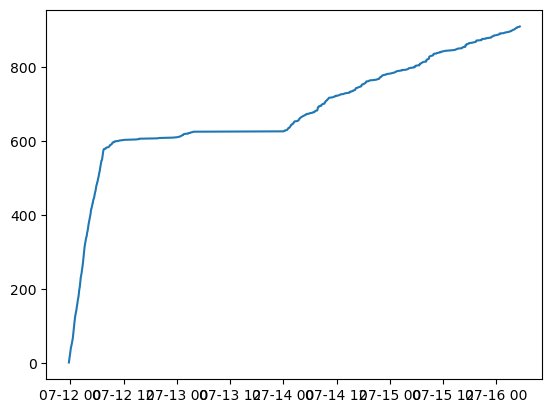

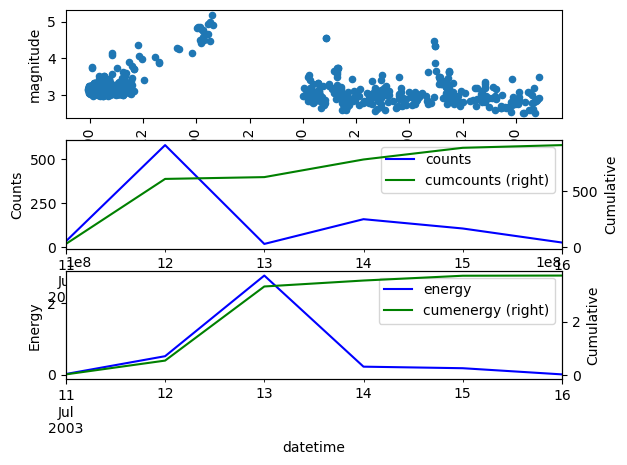

In [9]:
print(catalog_all)
catalog_all.plot_eventrate()
catalog_all.write_events(outdir=EVENTS_DIR, xmlfile='catalog.xml')

In [10]:
catalog_all.save(EVENTS_DIR,'catalog.pkl')

911 Event(s) in Catalog:
2003-07-11T23:40:24.226667Z | None, None | 3.14 None
2003-07-11T23:41:04.400000Z | None, None | 3.18 None
...
2003-07-16T05:09:45.626667Z | None, None | 3.51 None
2003-07-16T05:18:17.533334Z | None, None | 2.93 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'
                       magnitude        energy latitude longitude depth  \
datetime                                                                  
2003-07-11 18:00:00    98.016115  1.743185e+06        0         0     0   
2003-07-12 00:00:00  1425.833483  2.786629e+07        0         0     0   
2003-07-12 06:00:00   376.119087  1.448365e+07        0         0     0   
2003-07-12 12:00:00    15.215281  2.591841e+06        0         0     0   
2003-07-12 18:00:00    12.693174  6.840252e+06        0         0     0   
2003-07-13 00:00:00    76.012622  2.784037e+08        0         0     0   
2003-07-13 06:00:00     0.000000  0.000000e+00        0         0     0   
2003-07-13 12:

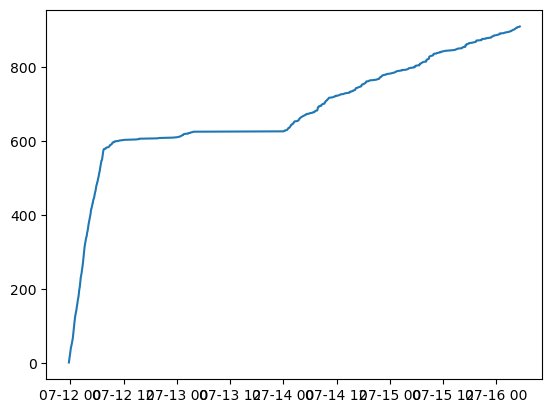

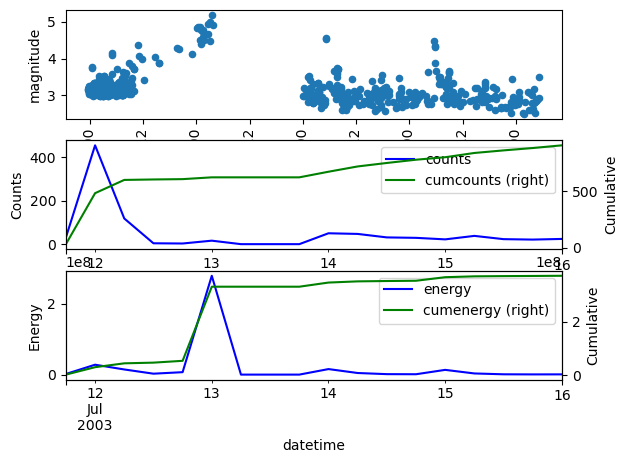

In [11]:
import importlib
importlib.reload(tools)
print(catalog_all)
catalog_all.plot_eventrate(binsize=pd.Timedelta(hours=6))
#catalog_all.write_events(outdir=EVENTS_DIR, xmlfile='catalog.xml')

                       magnitude        energy latitude longitude depth  \
datetime                                                                  
2003-07-11 18:00:00    98.016115  1.743185e+06        0         0     0   
2003-07-12 00:00:00  1425.833483  2.786629e+07        0         0     0   
2003-07-12 06:00:00   376.119087  1.448365e+07        0         0     0   
2003-07-12 12:00:00    15.215281  2.591841e+06        0         0     0   
2003-07-12 18:00:00    12.693174  6.840252e+06        0         0     0   
2003-07-13 00:00:00    76.012622  2.784037e+08        0         0     0   
2003-07-13 06:00:00     0.000000  0.000000e+00        0         0     0   
2003-07-13 12:00:00     0.000000  0.000000e+00        0         0     0   
2003-07-13 18:00:00     0.000000  0.000000e+00        0         0     0   
2003-07-14 00:00:00   154.690566  1.555716e+07        0         0     0   
2003-07-14 06:00:00   145.438791  4.485945e+06        0         0     0   
2003-07-14 12:00:00    92

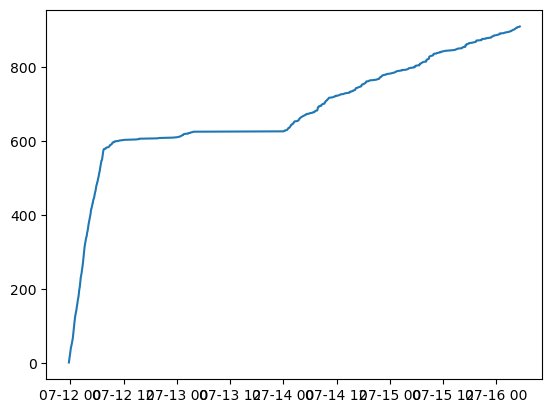

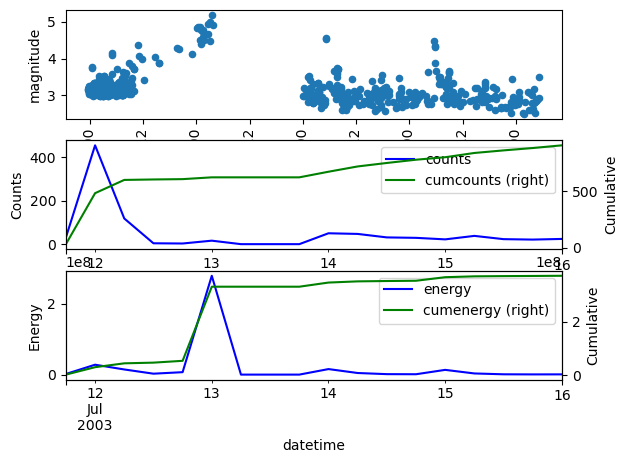

In [12]:
catalog_all.plot_eventrate(binsize=pd.Timedelta(hours=6))

In [13]:
# also swarm alarm system